In [1]:
# import packages
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.stats as stats
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

# For reading files and directories
import os

# Reading images into numpy arrays
from PIL import Image

# splitting, training, and testing
import sklearn.model_selection as ms

# Visualization
import sklearn.metrics as skm

# Eigenfaces and SVM
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

# edge detection
from skimage import feature


%matplotlib inline

In [2]:
def plot_gallery(images, h, w, n_row=3, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())

In [3]:
def plot_singleFace(image,h,w):
    """Helper function to plot a single image"""
    plt.imshow(image.reshape((height, width)), cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())

Import all images and convert to 3D numpy arrays. Then parse information for each image into dicts.

In [4]:
# create list to hold numpy arrays for each image
images = []
dirname = "./colorferet/front_thumbnails/"
for filename in sorted(os.listdir(dirname)):
    #print(filename)
    im = Image.open(os.path.join(dirname, filename)).convert("L") # "L" means b/w. comment out for color
    images.append(np.asarray(im, dtype=np.uint8))

X = np.array(images)
n_samples, height, width = X.shape
X = X.reshape([1364,-1])

print("Image size: \t\t[",width,",",height,"]")
print("Original image size:\t[ 512 , 768 ]")
print("Dimensions of X: \t[",X.shape[0],",",X.shape[1],"]")

Image size: 		[ 128 , 192 ]
Original image size:	[ 512 , 768 ]
Dimensions of X: 	[ 1364 , 24576 ]


In [5]:
# create list of dictionaries for each image's attributes
imData = [{} for _ in range(n_samples)]

dirname = "./colorferet/truths/"
filenames = sorted(os.listdir(dirname))
for i in range(n_samples):
    filename = filenames[i]
    textfile = open(os.path.join(dirname, filename))
    for str in textfile.read().split('\n'):
        if len(str) > 0:
            key, value = str.split('=')
        imData[i][key] = value
    textfile.close()

#imData[0]

In [6]:
# Create an index which gives all individuals with coordinate information
key = "nose_coordinates"
coord_idx = []
for i in range(n_samples):
    if key in imData[i]:
        coord_idx.append(i)
        imData[i]["x_nose"] = round(int(imData[i]["nose_coordinates"].rsplit(' ',1)[0])/4)
        imData[i]["y_nose"] = round(int(imData[i]["nose_coordinates"].rsplit(' ',1)[1])/4)
        imData[i]["x_leye"] = round(int(imData[i]["left_eye_coordinates"].rsplit(' ',1)[0])/4)
        imData[i]["x_reye"] = round(int(imData[i]["right_eye_coordinates"].rsplit(' ',1)[0])/4)
        imData[i]["y_leye"] = round(int(imData[i]["left_eye_coordinates"].rsplit(' ',1)[1])/4)
        imData[i]["y_reye"] = round(int(imData[i]["right_eye_coordinates"].rsplit(' ',1)[1])/4)
        imData[i]["x_mout"] = round(int(imData[i]["mouth_coordinates"].rsplit(' ',1)[0])/4)        
        imData[i]["y_mout"] = round(int(imData[i]["mouth_coordinates"].rsplit(' ',1)[1])/4)
                
        imData[i]["xdiff_eye"] = imData[i]["x_leye"] - imData[i]["x_reye"]
        imData[i]["ydiff_e2m"] = imData[i]["y_mout"] - np.mean((imData[i]["y_reye"],imData[i]["y_leye"]))
        
# removes irrelevant X & imData indices
imData = [imData[i] for i in coord_idx]
X = X[coord_idx]
n_samples = X.shape[0]

print("Dimensions of X: \t[",X.shape[0],",",X.shape[1],"]")

Dimensions of X: 	[ 1207 , 24576 ]


In [7]:
imData[8]

{'beard': 'No',
 'capture_date': '08/31/1993',
 'capture_time': '00:00:00',
 'collection': 'cfrC00001',
 'compression': 'bzip2',
 'disc': '1',
 'environment': 'cfrE00001',
 'expression': 'fa',
 'format': 'ppm',
 'glasses': 'No',
 'illuminant': 'cfrI00001 cfrI00002 cfrI00003',
 'left_eye_coordinates': '298 334',
 'mouth_coordinates': '248 452',
 'mustache': 'No',
 'nose_coordinates': '240 378',
 'pitch': '0',
 'pose': 'fa',
 'recording': 'cfrR00067',
 'relative': 'data/images/00004/00004_930831_fa.ppm.bz2',
 'right_eye_coordinates': '188 340',
 'roll': '0',
 'sensor': 'cfrN00002',
 'stage': 'cfrT00001',
 'subject': 'cfrS00004',
 'weather': 'inside',
 'x_leye': 74,
 'x_mout': 62,
 'x_nose': 60,
 'x_reye': 47,
 'xdiff_eye': 27,
 'y_leye': 84,
 'y_mout': 113,
 'y_nose': 94,
 'y_reye': 85,
 'yaw': '0',
 'ydiff_e2m': 28.5}

In [8]:
print("Samples with coordinate information: {:3.1f}%".format(100*len(coord_idx)/n_samples))

Samples with coordinate information: 100.0%


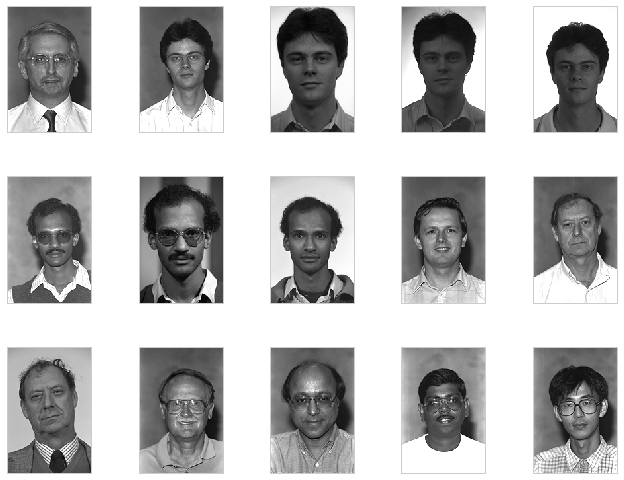

In [9]:
# Plot of first 15 images
plot_gallery(X[0:15], height, width)

Let's train a classifier to look for a mustache, glasses, or beard

In [10]:
# First let us crop each image so that it only shows the region near where a mustache might be
# Original image size is four times larger than thumbnail so coordinates are scaled by 1/4

y = []
x_nose    = []
x_leye    = []
y_leye    = []
x_reye    = []
y_reye    = []
y_nose    = []
x_mout    = []
y_mout    = []
xdiff_eye = []
ydiff_e2m = []
for i in range(n_samples):
    y.append(imData[i]['mustache'])
#    y.append(imData[i]['glasses'])
#    y.append(imData[i]['beard'])


    x_leye.append(imData[i]['x_leye'])
    y_leye.append(imData[i]['y_leye'])
    x_reye.append(imData[i]['x_reye'])
    y_reye.append(imData[i]['y_reye'])
    x_nose.append(imData[i]['x_nose'])
    y_nose.append(imData[i]['y_nose'])
    x_mout.append(imData[i]['x_mout'])
    y_mout.append(imData[i]['y_mout'])
    xdiff_eye.append(imData[i]['xdiff_eye'])
    ydiff_e2m.append(imData[i]['ydiff_e2m'])
    
y = pd.Series(y).replace(['No','Yes'],[0,1]).as_matrix()

# split into training and testing sets
X_train, X_test, y_train, y_test = ms.train_test_split(X,y,train_size=0.6)

In [11]:
imData[6]['x_leye']

82

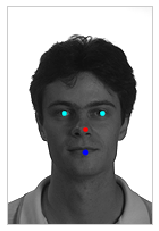

In [18]:
idx = 4
Ximg = X[idx].reshape((height,width))
#plot_singleFace(Ximg,height,width)
plt.imshow(Ximg.reshape((height, width)), cmap=plt.cm.gray)
plt.xticks(())
plt.yticks(())
plt.scatter(x_nose[idx],y_nose[idx],color='red',s=20)
plt.scatter(x_leye[idx],y_leye[idx],color='cyan',s=20)
plt.scatter(x_reye[idx],y_reye[idx],color='cyan',s=20)
plt.scatter(x_mout[idx],y_mout[idx],color='blue',s=30)
plt.show()

In [ ]:
nPCA = 80

print("Extracting the top %d eigenfaces from %d faces"
      % (nPCA, X_train.shape[0]))
pca = PCA(n_components=nPCA, svd_solver='randomized',
          whiten=True).fit(X_train)

eigenvalues = pca.explained_variance_
plt.figure(figsize=(6,4))
plt.plot(eigenvalues)
plt.xlabel("Eigenface #")
plt.ylabel("Eigenvalue")

In [ ]:
eigenfaces = pca.components_.reshape([nPCA, height, width])

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
#pseudoX_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# plot them creepy pictures
plot_gallery(eigenfaces[:8], height, width, 2, 4)
plot_gallery(eigenfaces[-8:], height, width, 2, 4)

In [ ]:
# select images with mustaches
def pseudoDataFunc(X,Y):
    posImages = X[Y.astype(bool)]
    negImages = X[~Y.astype(bool)]
    print("Number of images with target: {}".format(posImages.shape[0]))
    print("Number of images without target: {}".format(negImages.shape[0]))

    diff = negImages.shape[0]-posImages.shape[0]
    print("Number of new target samples needed: {}".format(diff))

    # Vector of random indices to select new images of mustaches
    indices = np.random.randint(0, high=posImages.shape[0], size=diff)

    pseudoDataList = []
    for i in range(len(indices)):
        pseudoDataList.append(posImages[indices[i]])

    pseudoData = np.array(pseudoDataList)
    
    # Adding noise
    #n,ndim = pseudoData.shape
    #bw = (n**(-1/(ndim+4))*np.std(pseudoX,axis=0))**2
    #pseudoData = pseudoData + np.round(np.random.normal(size=(n,ndim),scale=1))
    #pseudoData = np.clip(pseudoData,0,255)
    
    return pseudoData

# concatenate pseudoData onto training sets
pseudoX = pseudoDataFunc(X_train_pca, y_train)
pseudoX_train_pca = np.concatenate((X_train_pca, pseudoX), axis=0)
pseudoY_train = np.concatenate((y_train, np.ones(len(pseudoX))), axis=0)

In [ ]:
ImBack = pca.inverse_transform(X_train_pca)
plot_gallery(ImBack[:9], height, width, 3, 3)
# print(pseudoData.shape)
#print(sum(pseudoY_train)/len(pseudoY_train))


In [ ]:
print("Fitting the classifier to the training set")
param_grid = {'C': [1e1, 1e2, 1e3, 1e4],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
#clf = ms.GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=5)
#clf = clf.fit(X_train_pca, y_train)

#trainWeights = np.ones(len(y_train))
#trainWeights[np.where(y_train==1)] = (len(y_train) - np.sum(y_train))/np.sum(y_train) 

clf = GaussianNB()
clf.fit(pseudoX_train_pca, pseudoY_train)#, sample_weight = trainWeights)


#print("Best estimator found by grid search:")
#clf.best_estimator_

In [ ]:
#clf.cv_results_["mean_test_score"]

In [ ]:
#np.where(y_pred==1)

In [ ]:
y_pred = clf.predict(X_test_pca)
print(y_pred)
print(skm.classification_report(y_test, y_pred, target_names=['No', 'Yes']))

In [ ]:
idx=np.where(y_pred==1)[0][5:26]
plot_gallery(X_test[idx],height,width)
print(y_test[idx])
print(y_pred[idx])

In [ ]:
# Linear combination
def lin_combo(d3mat,vec):
    n,a,b = d3mat.shape
    X = np.zeros([a,b])
    for i in range(n):
        X = X + vec[i] * d3mat[i]
    return X

In [ ]:
zz = lin_combo(eigenfaces,X_train_pca[3,:])
plot_singleFace(zz,height,width)

In [ ]:
plot_singleFace(ImBack[3],height,width)

### plot_singleFace(ImBack[1],height,width)

In [ ]:
y_score = clf.score(X_test_pca, y_test)
print(y_score)

precision, recall, thresholds = skm.precision_recall_curve(y_test, y_pred, pos_label=1)

print("Precision: \t{}".format(precision))
print("Recall: \t{}".format(recall))
print("Thresholds: \t{}".format(thresholds))

F = 2*(precision[1]*recall[1])/(precision[1]+recall[1])

print("F score: {}".format(F))